In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import math
import torch
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from torch.autograd import Variable

In [3]:
from spacetime import SpaceTime
from spacetime.models import MLPEncoder, MLPDecoder
from spacetime.metrics import count_accuracy

In [4]:
class arguments:
    def __init__(self):
        # data parameters 
        # configurations
        self.node_dict = {0:[0,1], 1:[2], 2:[3,4]}
        self.data_variable_size=sum(map(len, self.node_dict.values()))
        self.data_sample_size=10000
        self.noise_scale = 1.0
        self.graph_type='erdos-renyi'
        self.graph_degree=3
        self.graph_sem_type='linear-gauss'
        self.graph_linear_type='nonlinear_2'
        self.edge_types=2
        self.x_dims=1 #changed here
        self.z_dims=1

        # training hyperparameters
        self.optimizer='Adam'
        self.graph_threshold=0.3  # 0.3 is good 0.2 is error prune
        self.tau_A=1e-10
        self.lambda_A=0.
        self.c_A=1
        self.ordered_graph=True
        self.use_A_connect_loss=False
        self.use_A_positiver_loss=False

        self.seed=42
        self.epochs= 10
        self.batch_size=200 # note: should be divisible by sample size otherwise throw an error
        self.lr=3e-3  # basline rate = 1e-3
        self.encoder_hidden=64
        self.decoder_hidden=64
        self.temp=0.5
        self.k_max_iter=1e2

        self.save_folder='logs'

        self.h_tol=1e-8
        self.prediction_steps=10 
        self.lr_decay=200
        self.gamma= 1.0
        self.skip_first=False
        self.var=5e-5
        self.hard=False
        self.prior=False
        self.dynamic_graph=False
        
args = arguments()

In [5]:
# compute constraint h(A) value
def _h_A(A, m):
    x = torch.eye(m).double()+ torch.div(A*A, m)
    expm_A = torch.matrix_power(x, m)
    return torch.trace(expm_A) - m

def _h_A_ordered(A, node_dict):
    h_A = 0
    block_row, block_col = 0, 0

    for t, time_slice in node_dict.items():
        block_width = len(time_slice)
        block = A[block_row:, block_col:block_col+block_width]
        h_A += torch.sum(block*block)
        
        block_row += block_width
        block_col += block_width
    return h_A

def stau(w, tau):
    w1 = torch.nn.Threshold(0.,0.)(torch.abs(w)-tau)
    return torch.sign(w)*w1

# matrix loss: makes sure at least A connected to another parents for child
def A_connect_loss(A, tol, z):
    d = A.size()[0]
    loss = 0
    for i in range(d):
        loss +=  2 * tol - torch.sum(torch.abs(A[:,i])) - torch.sum(torch.abs(A[i,:])) + z * z
    return loss

# element loss: make sure each A_ij > 0
def A_positive_loss(A, z_positive):
    result = - A + z_positive * z_positive
    loss =  torch.sum(result)

    return loss

def kl_gaussian_sem(preds):
    mu = preds
    kl_div = mu * mu
    kl_sum = kl_div.sum()
    return (kl_sum / (preds.size(0)))*0.5

def nll_gaussian(preds, target, variance, add_const=False):
    mean1 = preds
    mean2 = target
    neg_log_p = variance + torch.div(torch.pow(mean1 - mean2, 2), 2.*np.exp(2. * variance))
    if add_const:
        const = 0.5 * torch.log(2 * torch.from_numpy(np.pi) * variance)
        neg_log_p += const
    return neg_log_p.sum() / (target.size(0))

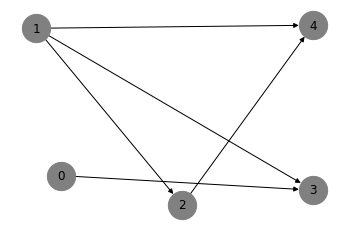

In [6]:
g = SpaceTime(args.node_dict)
g.generate_ordered(args.graph_degree, args.graph_type, seed=4)
g.generate_data(args.data_sample_size, args.x_dims, args.graph_sem_type, args.graph_linear_type, args.noise_scale)
g.time_order_nodes()
g.draw_graph()
# g.data[:2]
# g.ordered_adj()

In [7]:
#===================================
# training:
#===================================

def update_optimizer(optimizer, original_lr, c_A):
    '''related LR to c_A, whenever c_A gets big, reduce LR proportionally'''
    MAX_LR, MIN_LR = 1e-2, 1e-4

    estimated_lr = original_lr / (math.log10(c_A) + 1e-10)
    if estimated_lr > MAX_LR:
        lr = MAX_LR
    elif estimated_lr < MIN_LR:
        lr = MIN_LR
    else:
        lr = estimated_lr

    # set LR
    for parame_group in optimizer.param_groups:
        parame_group['lr'] = lr

    return optimizer, lr

def train(epoch, best_val_loss, ground_truth_G, lambda_A, c_A, optimizer):
    t = time.time()
    elbo_train = []
    nll_train = []
    shd_trian = []

    encoder.train()
    decoder.train()
    optimizer.step()
    scheduler.step()

    # update optimizer
    optimizer, lr = update_optimizer(optimizer, args.lr, c_A)

    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data).double()
        optimizer.zero_grad()

        enc_x, logits, origin_A, z_gap, z_positive, myA, Wa = encoder(data)  # logits is of size: [num_sims, z_dims]
        edges = logits
        dec_x, output = decoder(data, edges, args.data_variable_size*args.x_dims, origin_A, Wa)

        if torch.sum(output != output):
            print('nan error\n')

        target = data
        preds = output
        variance = 0.

        # compute h(A)
        if args.ordered_graph:
            h_A = _h_A_ordered(origin_A, args.node_dict)
        else:
            h_A = _h_A(origin_A, args.data_variable_size)
    
        # reconstruction accuracy loss
        loss_elbo = nll_gaussian(preds, target, variance) + kl_gaussian_sem(logits)
        loss_nll = nll_gaussian(preds, target, variance)
        
        loss = loss_elbo
        loss += lambda_A*h_A + 0.5*c_A*h_A*h_A + 100.*torch.trace(origin_A*origin_A)
        loss += args.tau_A*torch.sum(torch.abs(origin_A))

        # other loss terms
        if args.use_A_connect_loss:
            connect_gap = A_connect_loss(origin_A, args.graph_threshold, z_gap)
            loss += lambda_A*connect_gap + 0.5*c_A*connect_gap*connect_gap

        if args.use_A_positiver_loss:
            positive_gap = A_positive_loss(origin_A, z_positive)
            loss += 0.1*(lambda_A*positive_gap + 0.5*c_A*positive_gap*positive_gap)
            
        loss.backward()
        loss = optimizer.step()

        myA.data = stau(myA.data, args.tau_A*lr)

        if torch.sum(origin_A != origin_A):
            print('nan error\n')

        # compute metrics
        graph = origin_A.data.clone().numpy()
        graph[np.abs(graph) < args.graph_threshold] = 0

        fdr, tpr, fpr, shd, nnz = count_accuracy(ground_truth_G, nx.DiGraph(graph))

        elbo_train.append(loss_elbo.item())
        nll_train.append(loss_nll.item())
        shd_trian.append(shd)

    if 'graph' not in vars():
        print('error on assign')

    return np.mean(elbo_train), np.mean(nll_train), graph, origin_A

In [8]:
from spacetime.simulate import torch_loader
ground_truth_G, numpy_data = g.graph, g.data
train_loader, test_loader = torch_loader(ground_truth_G, numpy_data, args.batch_size)

In [9]:
import time
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import nn

Optimization Finished!
Best Epoch: 0008	 Best ELBO: 0.0462511960 Best NLL: 0.0021457166
Optimization Finished!
Best Epoch: 0009	 Best ELBO: 0.0399763815 Best NLL: 0.0005701463
Optimization Finished!
Best Epoch: 0004	 Best ELBO: 0.0250150558 Best NLL: 0.0003974457
Optimization Finished!
Best Epoch: 0009	 Best ELBO: 0.0202657790 Best NLL: 0.0003553858
Optimization Finished!
Best Epoch: 0006	 Best ELBO: 0.0158548737 Best NLL: 0.0003553858
Optimization Finished!
Best Epoch: 0009	 Best ELBO: 0.0123979804 Best NLL: 0.0001148268
Optimization Finished!
Best Epoch: 0009	 Best ELBO: 0.0111906869 Best NLL: 0.0000839978
Optimization Finished!
Best Epoch: 0009	 Best ELBO: 0.0103605644 Best NLL: 0.0000741041
Optimization Finished!
Best Epoch: 0009	 Best ELBO: 0.0096915098 Best NLL: 0.0000654856
Optimization Finished!
Best Epoch: 0009	 Best ELBO: 0.0089746560 Best NLL: 0.0000649833
Optimization Finished!
Best Epoch: 0009	 Best ELBO: 0.0083612712 Best NLL: 0.0000649833
Optimization Finished!
Best Epoc

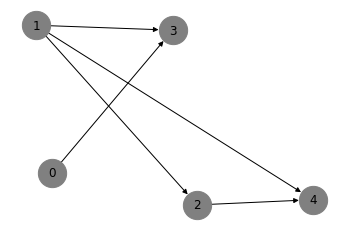

Ground truth graph
[[ 0.     0.     0.     0.797  0.   ]
 [ 0.     0.    -1.396  0.513  1.08 ]
 [ 0.     0.     0.     0.    -1.679]
 [ 0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.   ]]


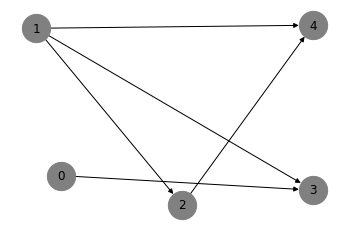

In [10]:
shd_trials = list()

for trial in range(1):
    t_total = time.time()

    best_ELBO_loss = np.inf
    best_epoch = 0
    best_ELBO_graph = None
    
    best_NLL_loss = np.inf
    best_NLL_graph = None

    # optimizer step on hyparameters
    c_A = args.c_A
    lambda_A = args.lambda_A
    h_A_new = torch.tensor(1.)
    h_tol = args.h_tol
    k_max_iter = int(args.k_max_iter)
    h_A_old = np.inf

    #===================================
    # load modules
    #===================================
    # add adjacency matrix A
    num_nodes = args.data_variable_size
    adj_A = np.zeros((num_nodes, num_nodes))

    encoder = MLPEncoder(args.data_variable_size*args.x_dims, args.x_dims, 
                         args.encoder_hidden, int(args.z_dims), adj_A).double()

    decoder = MLPDecoder(args.data_variable_size*args.x_dims, args.z_dims, 
                         args.x_dims, n_hid=args.decoder_hidden).double()

    #===================================
    # set up training parameters
    #===================================
    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()),lr=args.lr)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=args.lr_decay, gamma=args.gamma)
    
    #===================================
    # train model
    #===================================
    
    for step_k in range(k_max_iter):
        while c_A < 1e+20:
            for epoch in range(args.epochs):
                ELBO_loss, NLL_loss, graph, origin_A = train(epoch, best_ELBO_loss, ground_truth_G, lambda_A, c_A, optimizer)
                if ELBO_loss < best_ELBO_loss:
                    best_ELBO_loss = ELBO_loss
                    best_epoch = epoch
                    best_ELBO_graph = graph
                    
                if NLL_loss < best_NLL_loss:
                    best_NLL_loss = NLL_loss
                    best_epoch = epoch
                    best_NLL_graph = graph

            print("Optimization Finished!")
            print("Best Epoch: {:04d}\t".format(best_epoch),
                  "Best ELBO: {:.10f}".format(best_ELBO_loss),
                  "Best NLL: {:.10f}".format(best_NLL_loss))
            if ELBO_loss > 2 * best_ELBO_loss:
                break

            # update parameters
            A_new = origin_A.data.clone()
            
            if args.ordered_graph:
                h_A_new = _h_A_ordered(A_new, args.node_dict)
            else:
                h_A_new = _h_A(A_new, args.data_variable_size)

            if h_A_new.item() > 0.25 * h_A_old:
                c_A*=10
            else:
                break

            # update parameters
            # h_A, adj_A are computed in loss anyway, so no need to store

        h_A_old = h_A_new.item()
        lambda_A += c_A * h_A_new.item()

        if h_A_new.item() <= h_tol:
            break
    
    # test()
    fdr, tpr, fpr, shd, nnz = count_accuracy(ground_truth_G, nx.DiGraph(best_ELBO_graph))
    shd_trials.append(shd)
    
    print('Best ELBO Graph Accuracy: fdr', fdr, ' tpr ', tpr, ' fpr ', fpr, 'shd', shd, 'nnz', nnz)
    print(np.around(best_ELBO_graph, 3))
    g2 = SpaceTime()
    g2.graph = nx.DiGraph(best_ELBO_graph)
    g2.infer_order()
    g2.time_order_nodes()
    g2.draw_graph()

    print('Ground truth graph')
    print(np.around(g.ordered_adj(), 3))
    g.draw_graph()

In [11]:
def torch_graph(numpy_adj, mutilate = list()):
    graph = numpy_adj.copy()
    
    for i, j in mutilate:
        graph[i, j] = 0
        
    return nn.Parameter(torch.from_numpy(graph).double())

encoder.eval()
decoder.eval()

MLPEncoder(
  (fc1): Linear(in_features=1, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

MLPDecoder(
  (out_fc1): Linear(in_features=1, out_features=64, bias=True)
  (out_fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [12]:
data = next(iter(test_loader))[0].double()

_, z_train, graph, _, _, _, Wa_train = encoder(data)

In [13]:
graph_learn_full = torch_graph(graph.detach().numpy())
graph_learn = torch_graph(best_ELBO_graph)
graph_learn_mutil = torch_graph(best_ELBO_graph, mutilate = [(1, 2)])

graph_truth = torch_graph(g.ordered_adj())
graph_truth_mutil = torch_graph(g.ordered_adj(), mutilate = [(1, 2)])

In [14]:
graph_learn

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  1.6850,  0.0000],
        [ 0.0000,  0.0000, -2.2481,  0.9609,  1.2135],
        [ 0.0000,  0.0000,  0.0000,  0.0000, -1.9242],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]], dtype=torch.float64,
       requires_grad=True)

In [15]:
graph_learn_mutil

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  1.6850,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.9609,  1.2135],
        [ 0.0000,  0.0000,  0.0000,  0.0000, -1.9242],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]], dtype=torch.float64,
       requires_grad=True)

In [16]:
_, preds_train_full = decoder(data, z_train, args.data_variable_size*args.x_dims, graph_learn_full, Wa_train)
_, preds_train = decoder(data, z_train, args.data_variable_size*args.x_dims, graph_learn, Wa_train)
_, preds_train_mutil = decoder(data, z_train, args.data_variable_size*args.x_dims, graph_learn_mutil, Wa_train)


nll_gaussian(preds_train_full, data, 0.0)
nll_gaussian(preds_train, data, 0.0)

tensor(2.3029e-05, dtype=torch.float64, grad_fn=<DivBackward0>)

tensor(0.0114, dtype=torch.float64, grad_fn=<DivBackward0>)

In [17]:
z_test = list()

for i in range(5):
    mean = np.around(np.mean(z_train.detach().numpy()[:,i,:]), 7)
    std = np.around(np.std(z_train.detach().numpy()[:,i,:]), 3)
    z_test.append(np.random.normal(mean, std, 3000))
    print('%s \t mu_z: %s \t sigma_z: %s'%(i, mean, std))
    
z_test = torch.FloatTensor(np.array(z_test).T.reshape(len(z_test[0]), len(z_test), 1))

0 	 mu_z: 0.0005082 	 sigma_z: 0.027
1 	 mu_z: 0.000493 	 sigma_z: 0.027
2 	 mu_z: 0.0005945 	 sigma_z: 0.04
3 	 mu_z: 0.0004999 	 sigma_z: 0.033
4 	 mu_z: -0.0016065 	 sigma_z: 0.056


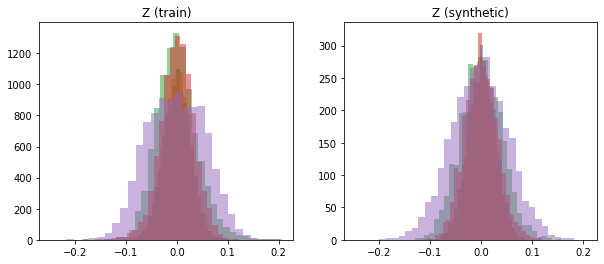

In [18]:
fig, axs = plt.subplots(1, 2, sharex=True, figsize = (10,4))

axs[0].set_title(r'Z (train)')
axs[1].set_title(r'Z (synthetic)')

for i in range(5):
    axs[0].hist(z_train.detach().numpy()[:,i,:], alpha=0.5, bins=30)
    axs[1].hist(z_test.numpy()[:,i,:], alpha=0.5, bins=30)
pass;

In [19]:
_, preds_test = decoder(data, z_test, args.data_variable_size*args.x_dims, graph_learn, Wa_train)
_, preds_test_mutil = decoder(data, z_test, args.data_variable_size*args.x_dims, graph_learn_mutil, Wa_train)

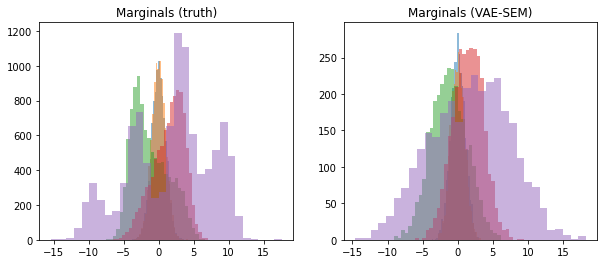

In [20]:
fig, axs = plt.subplots(1, 2, figsize = (10,4))

axs[0].set_title(r'Marginals (truth)')
axs[1].set_title(r'Marginals (VAE-SEM)')

for i in range(5):
    axs[0].hist(data.numpy()[:,i,:], alpha=0.5, bins=30)
    axs[1].hist(preds_test.detach().numpy()[:,i,:], alpha=0.5, bins=30)
pass;

In [21]:
class sampler:
    def __init__(self, data, bin_width = 1.0, discrete = False):
        self.discrete = discrete
        
        self.n = data.shape[0]
        self.n_vars = data.shape[1]
        
        self.data = np.squeeze(data)
        
        self.bin_width = bin_width
        self.joints = dict()
        self.axes = dict()
        
        for ivar in range(self.n_vars):
            self._compute_joint(ivar)
            
    def get_axes(self, *args):
        if args in self.joints:
            return self.axes[args]
        else:
            self._compute_joint(*args)
            return self.axes[args]
        
    def get_joint(self, *args):
        if args in self.joints:
            return self.joints[args]
        else:
            self._compute_joint(*args)
            return self.joints[args]
        
    def get_conditional(self, d_vars, c_vars):
        assert type(d_vars) == list and type(c_vars) == list
        joint_tag = tuple(d_vars + c_vars)
            
        num = self.get_joint(*joint_tag)
        den = np.tile(self.joints[tuple(c_vars[-1:])], 
                      tuple(list(num.shape)[:-1] + [1]*1))
        
        if len(c_vars) == 1:
            return np.nan_to_num(num/den)
        else:
            ## TODO: generalize to len(c) > 2
            den *= np.tile(self.get_conditional(c_vars[0:1], c_vars[1:]), 
                           tuple(list(num.shape)[:-len(c_vars)] + [1]*len(c_vars)))
            return np.nan_to_num(num/den)
        
    def _compute_joint(self, *args):
        bins = [self._bin_boundaries(i) for i in args]
        obs = self.data[:, list(args)]
        joint, bnds = np.histogramdd(obs, bins=bins, density=True)
        axes = [self._bin_centers(bnd) for bnd in bnds]
        self.joints[args] = joint
        self.axes[args] = axes
            
    def _bin_boundaries(self, ivar):
        pad_lower = 0 if not self.discrete else -0.5
        pad_upper = 0 if not self.discrete else 1.5

        boundaries = np.arange(np.floor(self.data[:, ivar].min())+pad_lower, 
                               np.ceil(self.data[:, ivar].max())+pad_upper, 
                               self.bin_width)
        return boundaries
    
    def _bin_centers(self, boundaries):
        centers = np.array([0.5*(boundaries[i]+boundaries[i+1]) 
                            for i, x in enumerate(boundaries[:-1])])
        return centers
    
    def get_plot_marginal(self, var):
        joint, axes = self.get_joint(var), self.get_axes(var)
        return axes[0], joint
    
    def get_contour_joint(self, var_x, var_y):
        joint, axes = self.get_joint(var_x, var_y), self.get_axes(var_x, var_y)
        mesh = np.meshgrid(*axes)
        return mesh[0], mesh[1], joint.T
    
    def get_contour_conditional(self, d_vars, c_vars):
        assert type(d_vars) == list and type(c_vars) == list
        joint_tag = tuple(d_vars + c_vars)
        conditional = self.get_conditional(d_vars, c_vars)
        axes = self.get_axes(*joint_tag)
        mesh = np.meshgrid(*axes)
        return mesh[0], mesh[1], conditional.T

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [22]:
p_train_full = sampler(preds_train_full.detach().numpy(), bin_width = args.noise_scale)
p_train = sampler(preds_train.detach().numpy(), bin_width = args.noise_scale)
p_train_mutil = sampler(preds_train_mutil.detach().numpy(), bin_width = args.noise_scale)

p_test = sampler(preds_test.detach().numpy(), bin_width = args.noise_scale)
p_test_mutil = sampler(preds_test_mutil.detach().numpy(), bin_width = args.noise_scale)

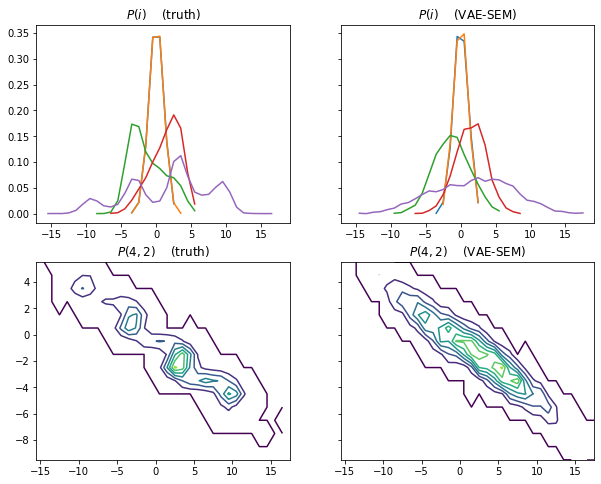

In [23]:
fig, axs = plt.subplots(2, 2, sharex='row', sharey='row', figsize = (10,8))

axs[0][0].set_title(r'$P(i)$    (truth)')
axs[0][1].set_title(r'$P(i)$    (VAE-SEM)')

axs[1][0].set_title(r'$P(4,2)$    (truth)')
axs[1][1].set_title(r'$P(4,2)$    (VAE-SEM)')

for i in range(5):
    axs[0][0].plot(*p_train.get_plot_marginal(i))
    axs[0][1].plot(*p_test.get_plot_marginal(i))
    
axs[1][0].contour(*p_train.get_contour_joint(4, 2))
axs[1][1].contour(*p_test.get_contour_joint(4, 2))
pass;

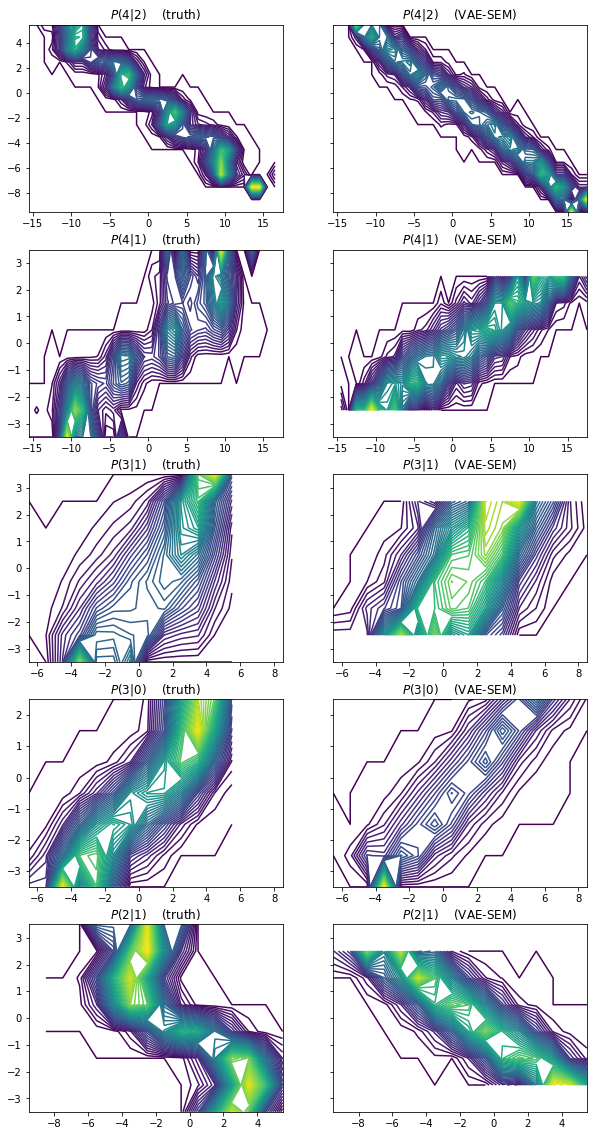

In [24]:
fig, axs = plt.subplots(5, 2, sharex='row', sharey='row', figsize = (10,20))

axs[0][0].set_title(r'$P(4|2)$    (truth)')
axs[0][1].set_title(r'$P(4|2)$    (VAE-SEM)')

axs[1][0].set_title(r'$P(4|1)$    (truth)')
axs[1][1].set_title(r'$P(4|1)$    (VAE-SEM)')

axs[2][0].set_title(r'$P(3|1)$    (truth)')
axs[2][1].set_title(r'$P(3|1)$    (VAE-SEM)')

axs[3][0].set_title(r'$P(3|0)$    (truth)')
axs[3][1].set_title(r'$P(3|0)$    (VAE-SEM)')

axs[4][0].set_title(r'$P(2|1)$    (truth)')
axs[4][1].set_title(r'$P(2|1)$    (VAE-SEM)')

axs[0][0].contour(*p_train.get_contour_conditional([4],[2]), levels=50)
axs[0][1].contour(*p_test.get_contour_conditional([4],[2]), levels=50)

axs[1][0].contour(*p_train.get_contour_conditional([4],[1]), levels=50)
axs[1][1].contour(*p_test.get_contour_conditional([4],[1]), levels=50)

axs[2][0].contour(*p_train.get_contour_conditional([3],[1]), levels=50)
axs[2][1].contour(*p_test.get_contour_conditional([3],[1]), levels=50)

axs[3][0].contour(*p_train.get_contour_conditional([3],[0]), levels=50)
axs[3][1].contour(*p_test.get_contour_conditional([3],[0]), levels=50)

axs[4][0].contour(*p_train.get_contour_conditional([2],[1]), levels=50)
axs[4][1].contour(*p_test.get_contour_conditional([2],[1]), levels=50)
pass;

In [25]:
def Pi_UNj_DOk(i, j, k, sampler):
    do = np.zeros(sampler.get_joint(i, k).shape)
    
    for n in range(len(sampler.joints[(j,)])):
        do += sampler.get_conditional([i], [j, k])[:,n,:]*sampler.joints[(j,)][n]
    return do

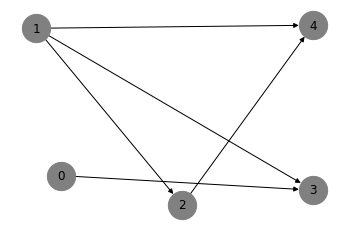

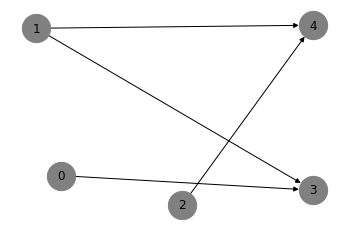

In [26]:
from copy import deepcopy

g3 = deepcopy(g)
g3.graph.remove_edge(1,2)

g.draw_graph()
g3.draw_graph()

/home/q1park/anaconda3/envs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


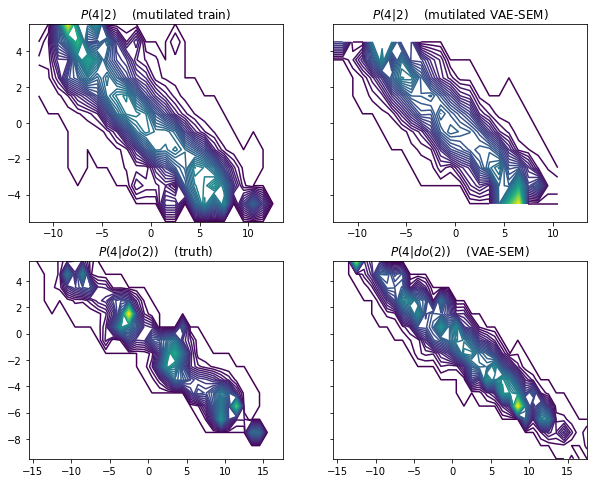

In [27]:
fig, axs = plt.subplots(2, 2, sharex='row', sharey='row', figsize = (10,8))

axs[0][0].set_title(r'$P(4|2)$    (mutilated train)')
axs[0][1].set_title(r'$P(4|2)$    (mutilated VAE-SEM)')

axs[1][0].set_title(r'$P(4|do(2))$    (truth)')
axs[1][1].set_title(r'$P(4|do(2))$    (VAE-SEM)')

axs[0][0].contour(*p_train_mutil.get_contour_conditional([4],[2]), levels=50)
axs[0][1].contour(*p_test_mutil.get_contour_conditional([4],[2]), levels=50)

axs[1][0].contour(*np.meshgrid(*p_train.get_axes(4, 2)), Pi_UNj_DOk(4,1,2, p_train).T, levels=50)
axs[1][1].contour(*np.meshgrid(*p_test.get_axes(4, 2)), Pi_UNj_DOk(4,1,2, p_test).T, levels=50)
pass;

In [28]:
# stone_data = np.array([[[0.], [0.], [1.]]]*84 + 
#                       [[[0.], [0.], [0.]]]*(87-84) + 
#                       [[[0.], [1.], [1.]]]*234 + 
#                       [[[0.], [1.], [0.]]]*(270-234) + 
#                       [[[1.], [0.], [1.]]]*192 + 
#                       [[[1.], [0.], [0.]]]*(263-192) + 
#                       [[[1.], [1.], [1.]]]*55 + 
#                       [[[1.], [1.], [0.]]]*(80-55))

# prob2 = sampler(stone_data, bin_width = 1., discrete = True)
# prob2.get_conditional([2],[0])[1,:]
# prob2.get_conditional([2],[1])[1,:]
# prob2.joints

# prob2.get_conditional([2],[0,1])[:,0,0]*prob2.joints[(0,)]['joint'][0] + \
# prob2.get_conditional([2],[0,1])[:,1,0]*prob2.joints[(0,)]['joint'][1]

# prob2.get_conditional([2],[0,1])[:,0,1]*prob2.joints[(0,)]['joint'][0] + \
# prob2.get_conditional([2],[0,1])[:,1,1]*prob2.joints[(0,)]['joint'][1]

# prob2.get_conditional([2],[0,1])[:,0,:]*prob2.joints[(0,)]['joint'][0] + \
# prob2.get_conditional([2],[0,1])[:,1,:]*prob2.joints[(0,)]['joint'][1]

In [29]:
# shd_trials
# np.mean(shd_trials)
# np.std(shd_trials)

####### node_dict = {0:[0,1], 1:[2,3,4], 2:[5,6]}
#### noise = 0.05
### h_A experiments
# [9, 9, 11, 9, 9, 10, 9, 6, 9, 7]
# 8.8 +- 1.32664991614216
### h_A_ordered experiments
# [2, 6, 7, 5, 5, 4, 6, 7, 6, 6]
# 5.4 +- 1.42828568570857

#### noise = 0.1
### h_A experiments
# [7, 8, 7, 9, 8, 8, 4, 9, 5, 8]
# 7.3 +- 1.5524174696260025
### h_A_ordered experiments
# [1, 1, 5, 4, 4, 4, 4, 5, 3, 1]
# 3.2 +- 1.5362291495737217